# Datojen haku ja esikäsittely

In [1]:
from set_path import set_path
mainpath, path = set_path('areadata')

In [2]:
from read_and_prepare_data import read_and_prepare_data
stat, post, kunta_stat, vaalidata = read_and_prepare_data(path)

read_and_prepare_data  read from file
read_post_muncipalities  read from file


In [3]:
from selected_cols import selected_cols
numeric_features, categorical_features = selected_cols(largeset=False, parties=True)

Create model
Number of clusters: 6 Silhouette Coefficient: 0.163 Calinski Harabaz Index: 324
1    1064
0     928
3     351
5     341
4     155
2     131
Name: cluster, dtype: int64


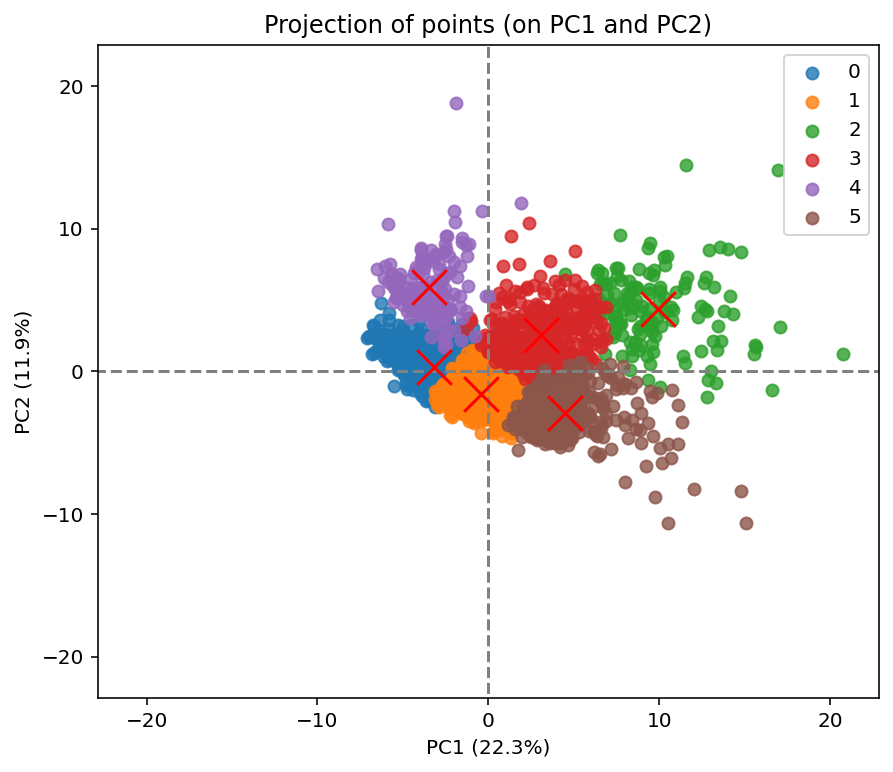

In [4]:
from sklearn.feature_selection import  mutual_info_classif
import pandas as pd
from sklearn.cluster import KMeans
import shap

from draw_and_create_clusters import create_kmeans_clusters 
from draw_and_create_clusters import draw_clusters, draw_pca, drawTSNE,  display_scree_plot, display_circles, display_parallel_coordinates_centroids, display_factorial_planes

from prepare_and_scale_data import prepare_and_scale_data
from create_prediction import select_kbest
from select_columns_and_clean_data import select_columns_and_clean_data
from draw_all import draw_features

from shap_Xboost import shap_Xboost
from shap_proba_individual import shap_proba_individual, print_individual, print_reason, print_individual_waterfall
from shap_vals import shap_vals
from print_examples import print_examples


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_colwidth = 100


#valitaan käsittelyyn tuleva alue PKS
selected = stat[(stat['muncipality_code']==91) | (stat['muncipality_code']==92) | (stat['muncipality_code']==49) | (stat['muncipality_code']==235)].copy()
selected_vaalidata = vaalidata[(vaalidata['Kuntanumero']==91) | (vaalidata['Kuntanumero']==92) | (vaalidata['Kuntanumero']==49) | (vaalidata['Kuntanumero']==235) ].copy()
post_included = post[(post['muncipality_code']==91) | (post['muncipality_code']==92) | (post['muncipality_code']==49) | (post['muncipality_code']==235)]['postcode'].copy()

#valitaan käsittelyyn tuleva alue FI1B1 = Uusimaa
selected = stat[stat['area_code']=='FI1B1'].copy()
selected_vaalidata = vaalidata[vaalidata['area_code']=='FI1B1'].copy()
post_included = post[post['area_code']=='FI1B1'].copy()

selected = stat.copy()
selected_vaalidata = vaalidata.copy()
post_included = post.copy()

n_components = 2
n_clusters = 6
axis_ranks=  [(0,1)]
alpha = 0.8
scaled = True
silhouette_print = 0

filename_model = 'kmeans_cluster'
data, X, test, kmeans = create_kmeans_clusters(filename_model, path, selected, selected, numeric_features=numeric_features, categorical_features=categorical_features, n_clusters=n_clusters, silhouette_print=silhouette_print, scaled=scaled)

print(data['cluster'].value_counts())
display_factorial_planes(kmeans, data, X, n_components=n_components, axis_ranks=axis_ranks, labels=None, alpha=alpha)

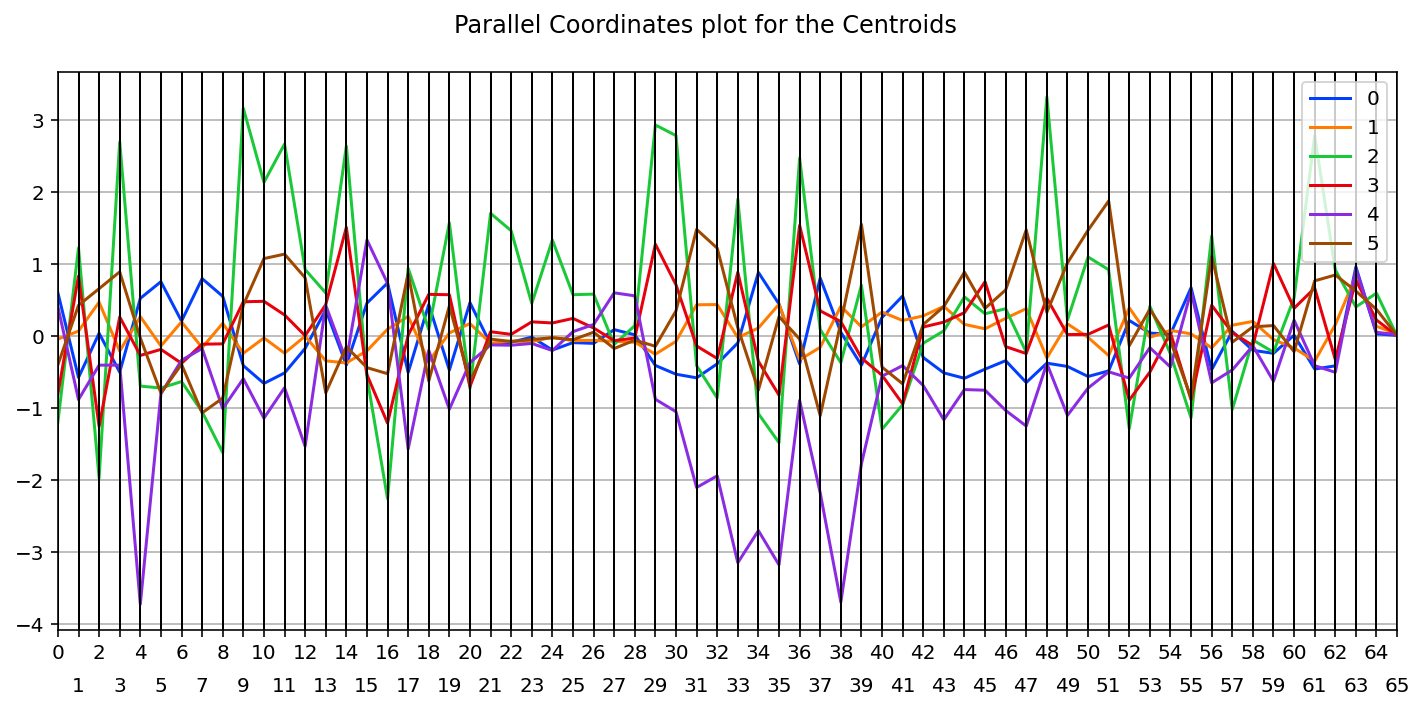

In [5]:
labels = [X.columns.get_loc(c) for c in X.columns]
centroids=display_parallel_coordinates_centroids(kmeans, labels=labels)
cols = X.columns.to_list()
cols.append('cluster')
centroids.columns = cols

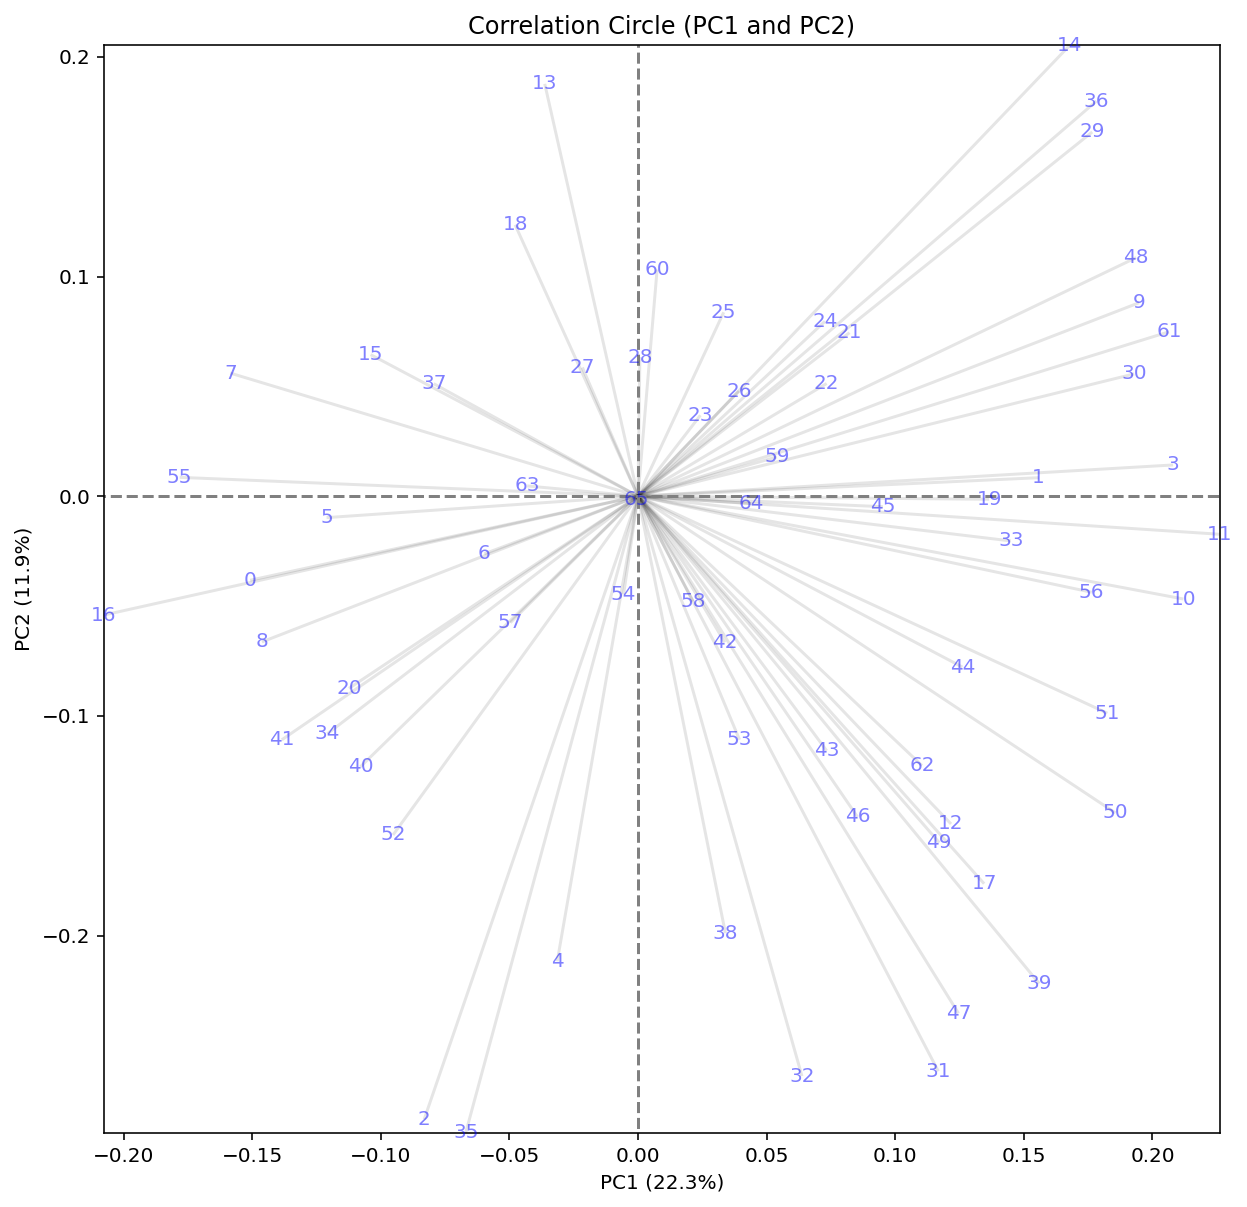

In [6]:
axis_ranks =  [(0,1)]
n_components = 2
labels = [X.columns.get_loc(c) for c in X.columns]

pcs = display_circles(X, n_components=n_components, axis_ranks=axis_ranks, labels=labels, label_rotation=0, lims=None)

In [7]:
for c in X.columns:
    print(X.columns.get_loc(c), c)

0 Miehet, 2018 (HE) osuudesta asukkaat
1 Naiset, 2018 (HE) osuudesta asukkaat
2 Asuntojen keskipinta-ala, 2018 (RA) osuus total
3 Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total
4 Asumisväljyys, 2018 (TE) osuus total
5 Asukkaiden keski-ikä, 2018 (HE) osuus total
6 Postinumeroalueen pinta-ala osuus area_code
7 Perusasteen suorittaneet, 2018 (KO) osuudesta asukkaat
8 Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
9 Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
10 Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
11 Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat
12 Asukkaiden ostovoimakertymä, 2017 (HR) osuudesta asukkaat osuus total
13 Asunnot, 2018 (RA) osuudesta asukkaat
14 Kerrostaloasunnot, 2018 (RA) osuudesta asukkaat
15 Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat
16 Pientaloasunnot, 2018 (RA) osuudesta asukkaat
17 Työlliset, 2017 (PT) osuudesta asukkaat
18 Työttömät, 2017 (PT) osuudesta

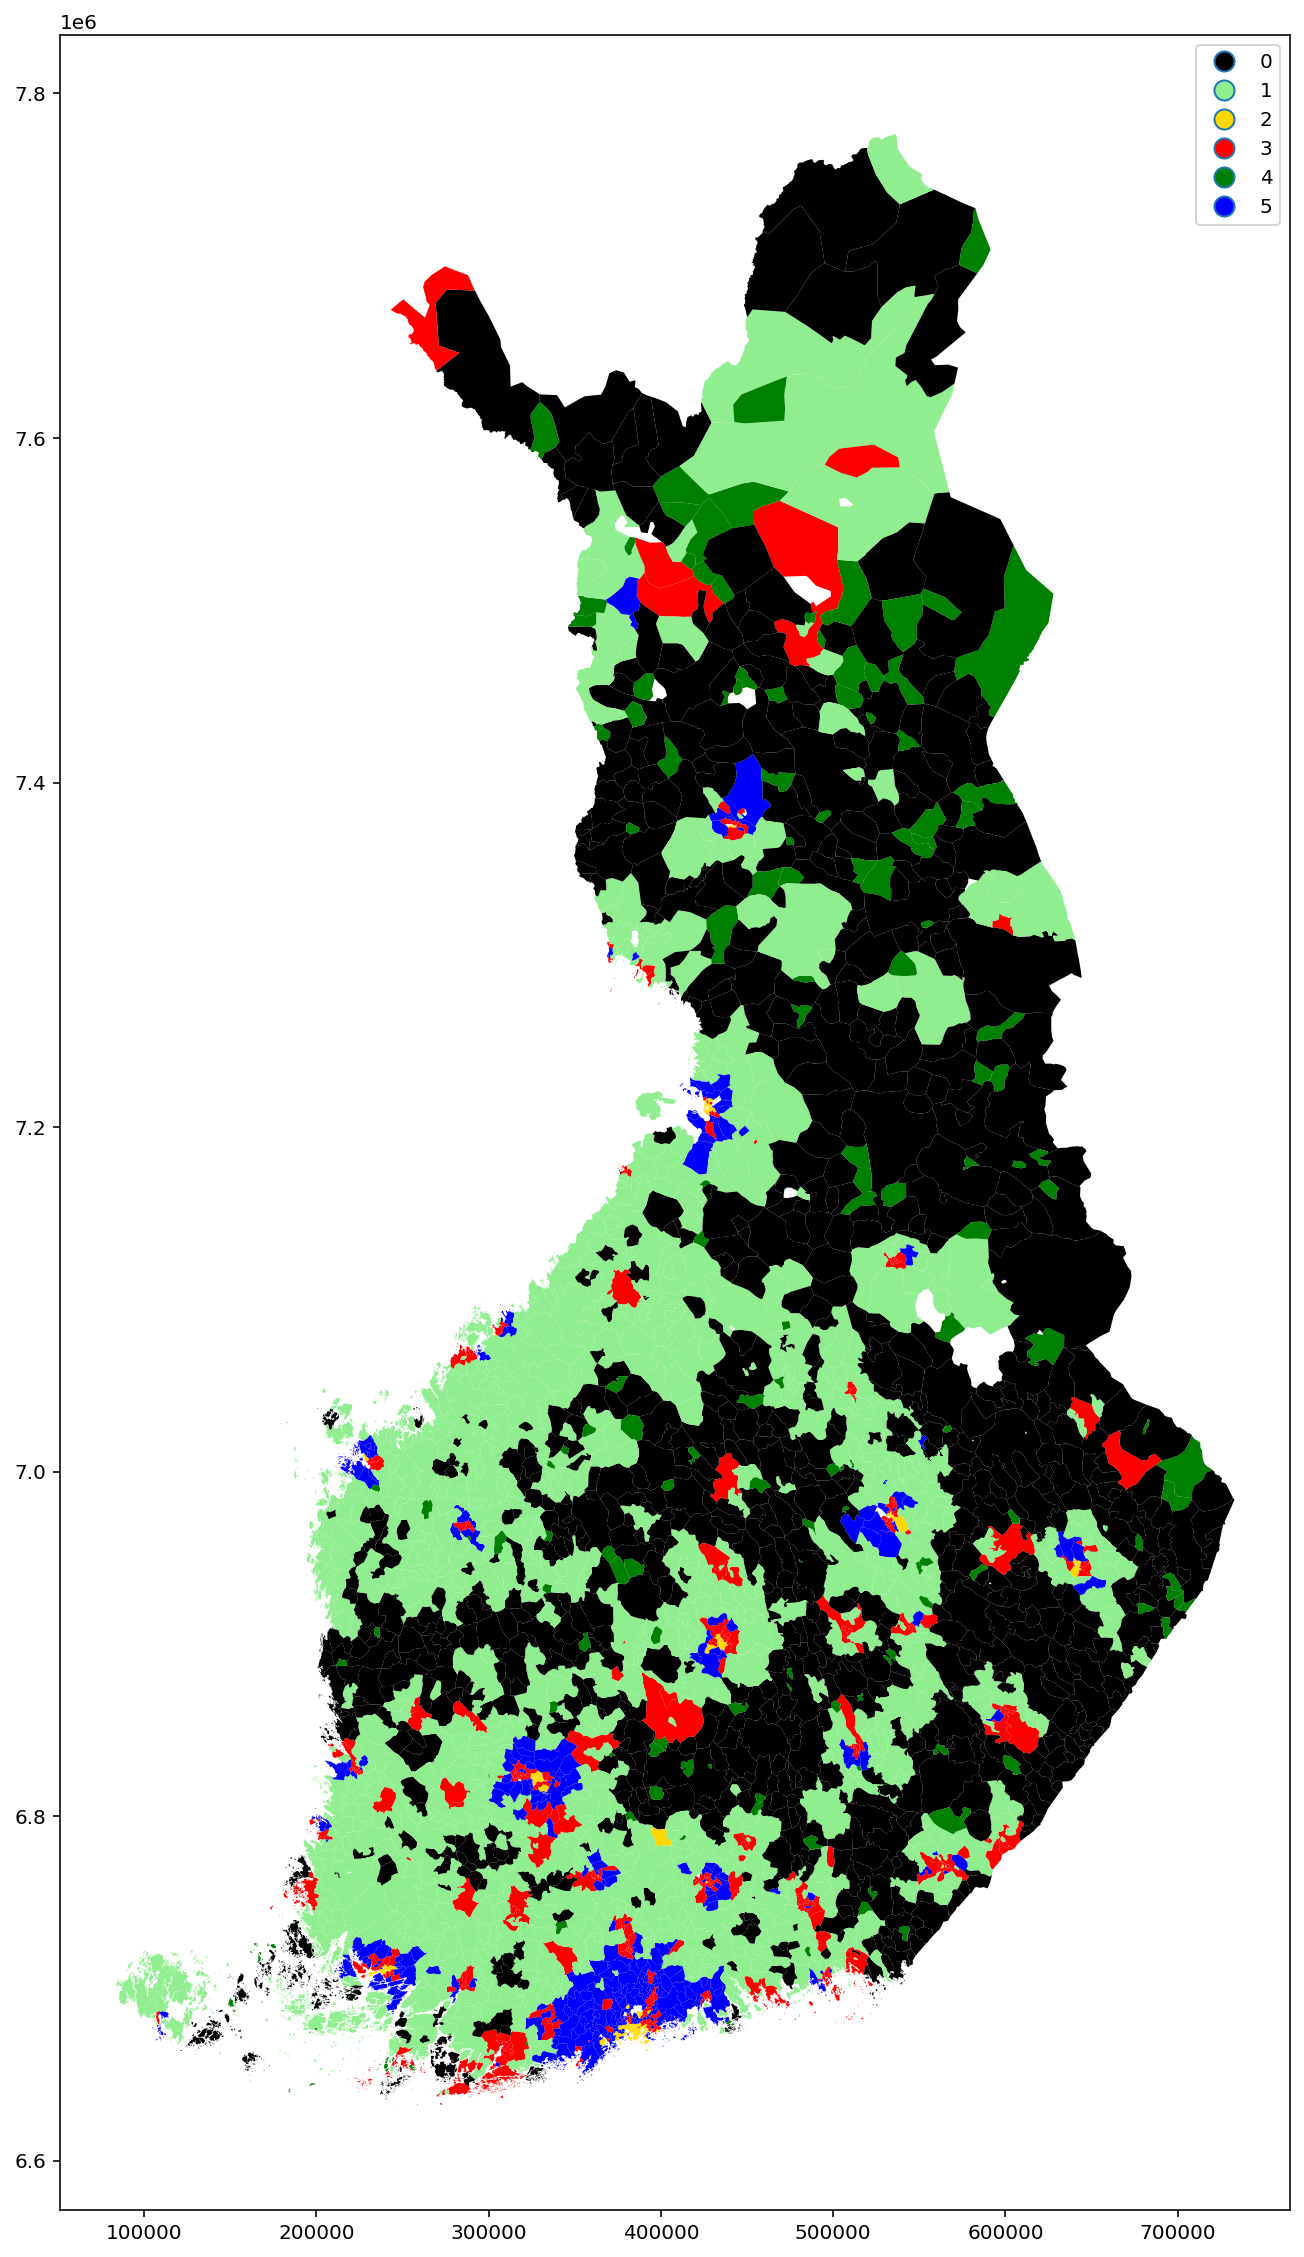

In [8]:
import geopandas
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my cmap', ['black', 'lightgreen', 'gold',  'red',  'green', 'blue'])
draw = geopandas.GeoDataFrame(pd.DataFrame(data[['cluster', 'geometry']], dtype=object),geometry='geometry')
draw.plot(column='cluster', cmap=cmap, legend=True, figsize=(20,20))

In [9]:
import xgboost as xgb
from sklearn.feature_selection import  mutual_info_classif
from create_prediction import create_prediction

target = 'cluster'

ennustettu = "uusi" + target

#Check
#k_selected need to have correct values, if they are too large, evrything needs to be started again
k_selected = 'all'

test_size = 0.2

#Scalers attributes
kbest_score_func = mutual_info_classif
#set values to model configuration attributes

num_class = len(data['cluster'].unique()) #how many classes we are working with

metric = 'merror'
Skfold=True
Verbose = False
testing=True
scaled = False

params = {
    # Parameters that we are going to tune.
    'objective':'multi:softmax',
    'num_class' : num_class,
    'booster' : 'gbtree',
    'eval_metric' : metric
}

filename_model = 'kmeans_xgboost_cluster'
data, test, features_df, importance_df, model, params, y_pred, X_train, y_train, X_test, y_test = create_prediction(filename_model, path, data, data, target, kbest_score_func, metric, params, numeric_features, categorical_features, scaled=scaled, testing=testing)
data_no_use, X_scale, X = prepare_and_scale_data(data, pd.DataFrame(), numeric_features, categorical_features)


Create model
[0]	train-merror:0.05345	test-merror:0.13300
Multiple eval metrics have been passed: 'test-merror' will be used for early stopping.

Will train until test-merror hasn't improved in 50 rounds.
Stopping. Best iteration:
[52]	train-merror:0.00000	test-merror:0.07239

testing
Start with xgb.cv params: merror: 0.06649800000000002
Best xgb.cv params: max_depth 2, min_child_weight 2, merror: 0.058922333333333334
Best xgb.cv params: gamma 0.0, merror: 0.058922333333333334
Best xgb.cv params: lambda 1.0, alpha 0.4, merror: 0.05850166666666667
Best xgb.cv params: colsample_bytree 0.2, subsample 0.6, merror: 0.05513466666666667
Best xgb.cv params: eta 0.2, merror: 0.061026666666666673
Found hyperparameters with 1 rounds 
{'objective': 'multi:softmax', 'num_class': 6, 'booster': 'gbtree', 'eval_metric': 'merror', 'max_depth': 2, 'min_child_weight': 2, 'gamma': 0.0, 'lambda': 1.0, 'alpha': 0.4, 'colsample_bytree': 0.2, 'subsample': 0.6, 'eta': 0.2}

[0]	train-merror:0.21549	test-merror

In [11]:
filename_model = 'kmeans_mymodel_xgboost_cluster'
mymodel, explainer, shap_values, shap_interaction_values, shap_expected_value = shap_Xboost(filename_model, path, data, target, params, X)

Create model


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [12]:
data[ennustettu] = mymodel.predict(X)
data["ennustettu 2"] = model.predict(xgb.DMatrix(X, label=data[target]))

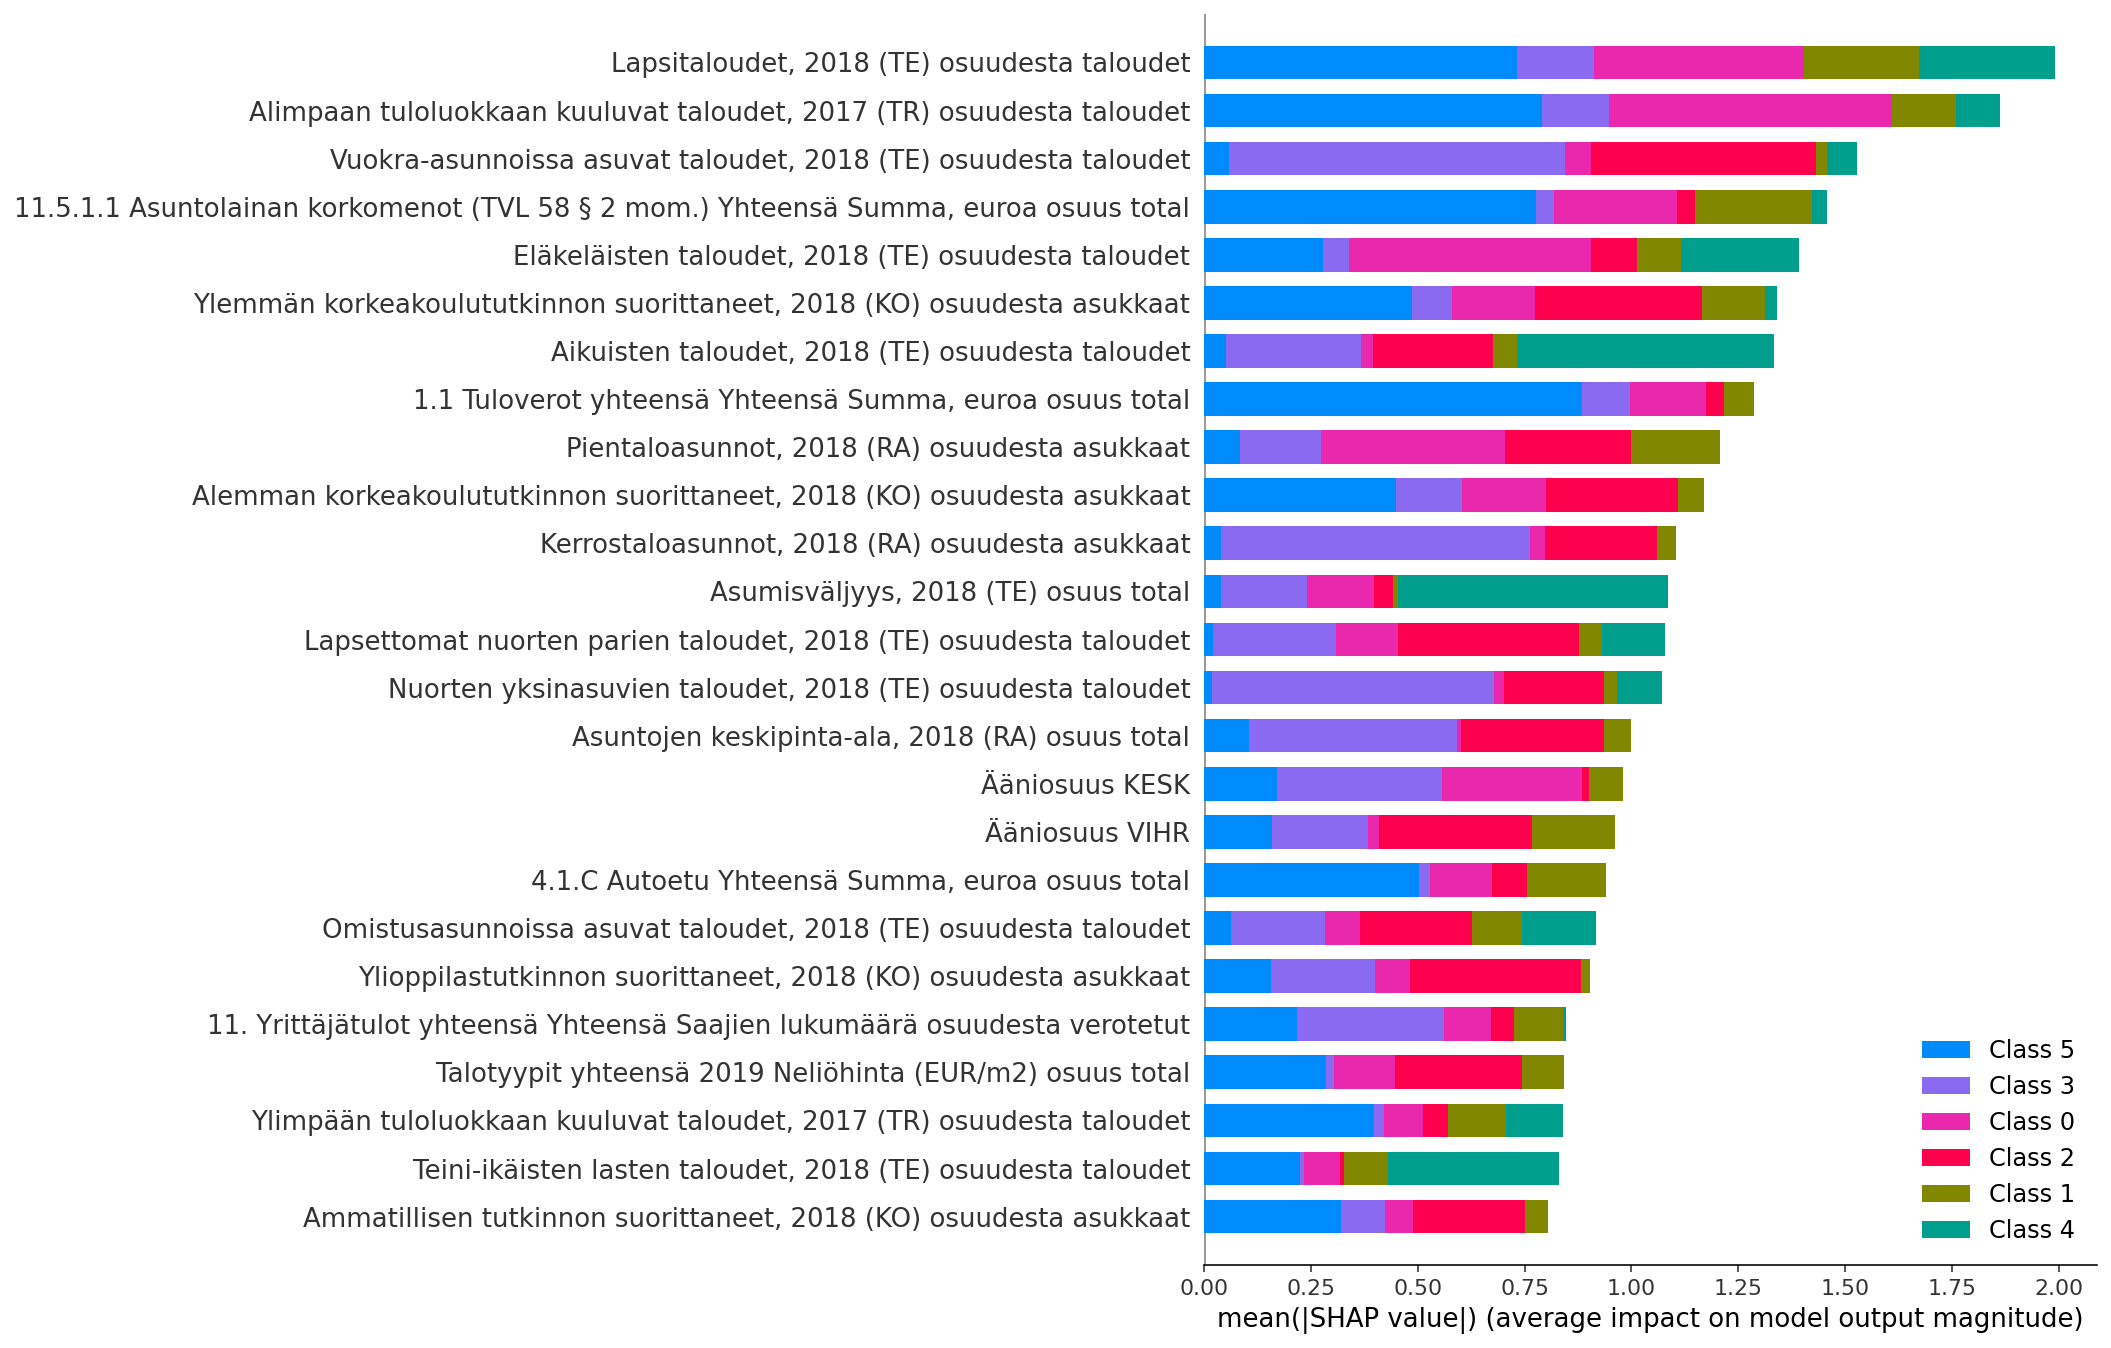

In [14]:
shap.summary_plot(shap_values, X,  max_display=25)

In [142]:
pnro = '02610'
id_col = 'Postinumero'
df, X_rand, clst = shap_proba_individual(explainer, mymodel, data, target, X, id_col, pnro, log=True)

In [143]:
print_reason(X_rand, explainer, shap_values, mymodel, clst)

Class:  2
Base value:  0.27806985
Prediction value:  10.097098
Converted Proba value: 0.9916571
Proba value: 0.99165714 



In [ ]:

id_col = 'Postinumero'
party ='KOK'
target = 'Äänet yhteensä lkm ' + party
df, X_rand, clst = shap_proba_individual(explainer[key], mymodel[key], data, target, X, id_col, pnro)

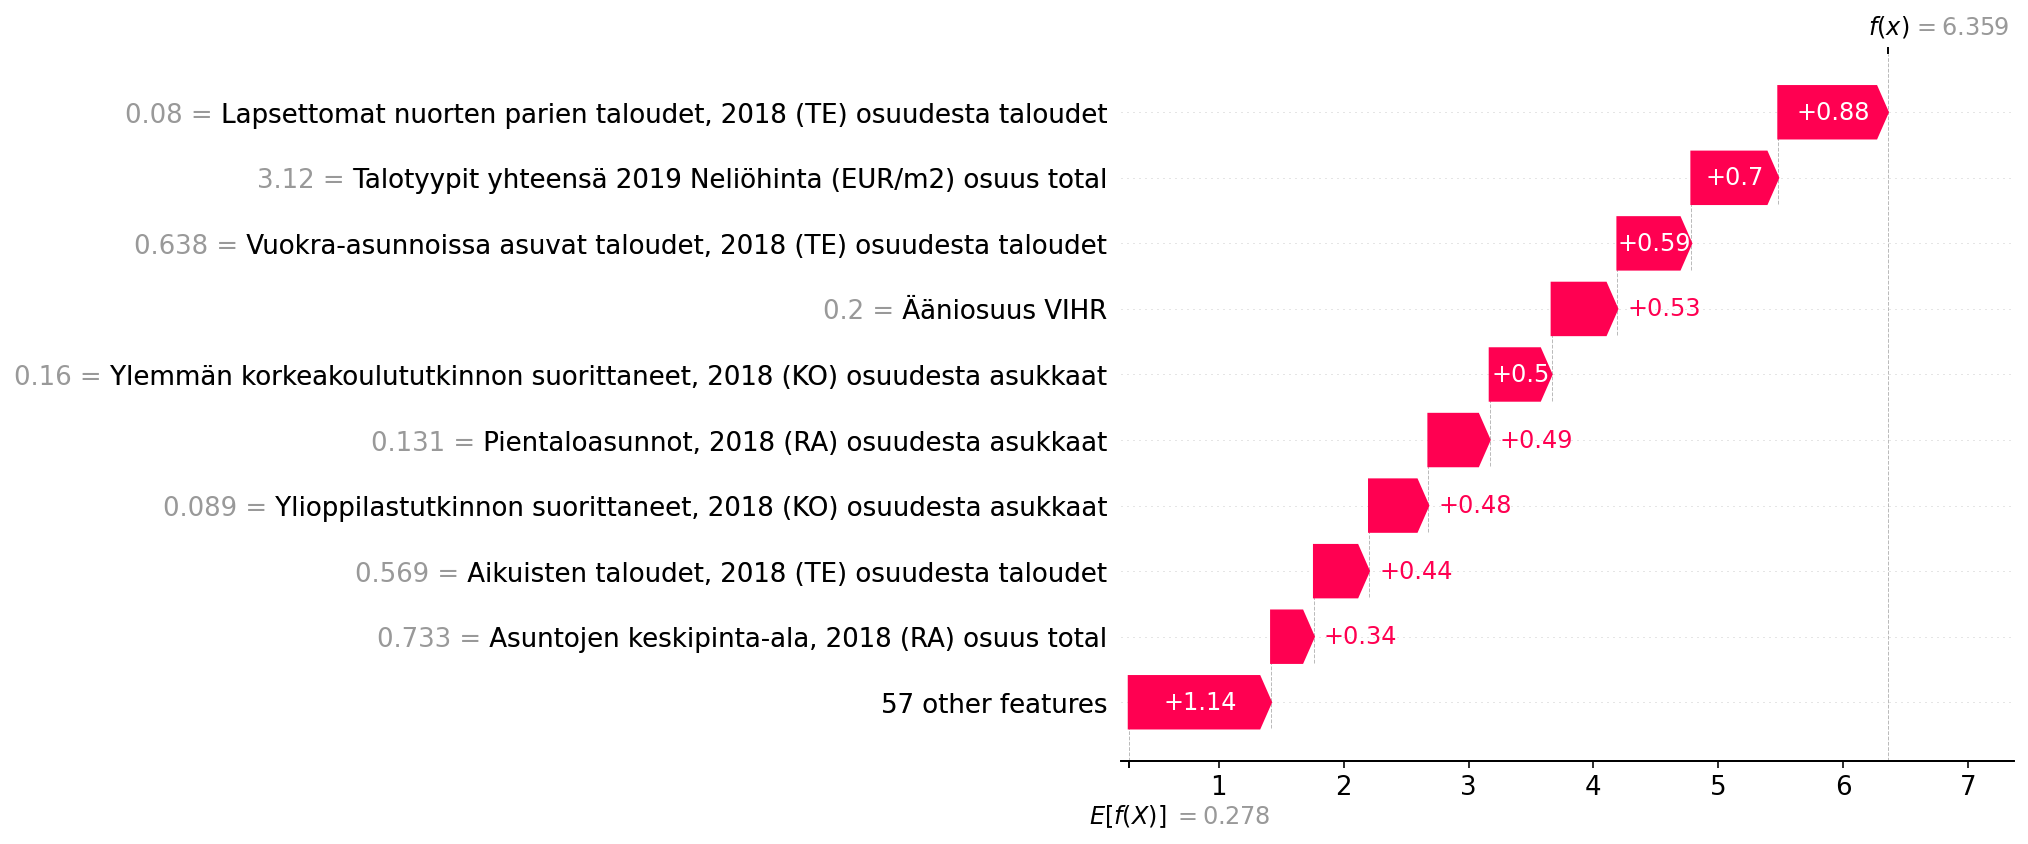

In [144]:
print_individual_waterfall(data, target, X, shap_expected_value, shap_values, id_col, pnro)

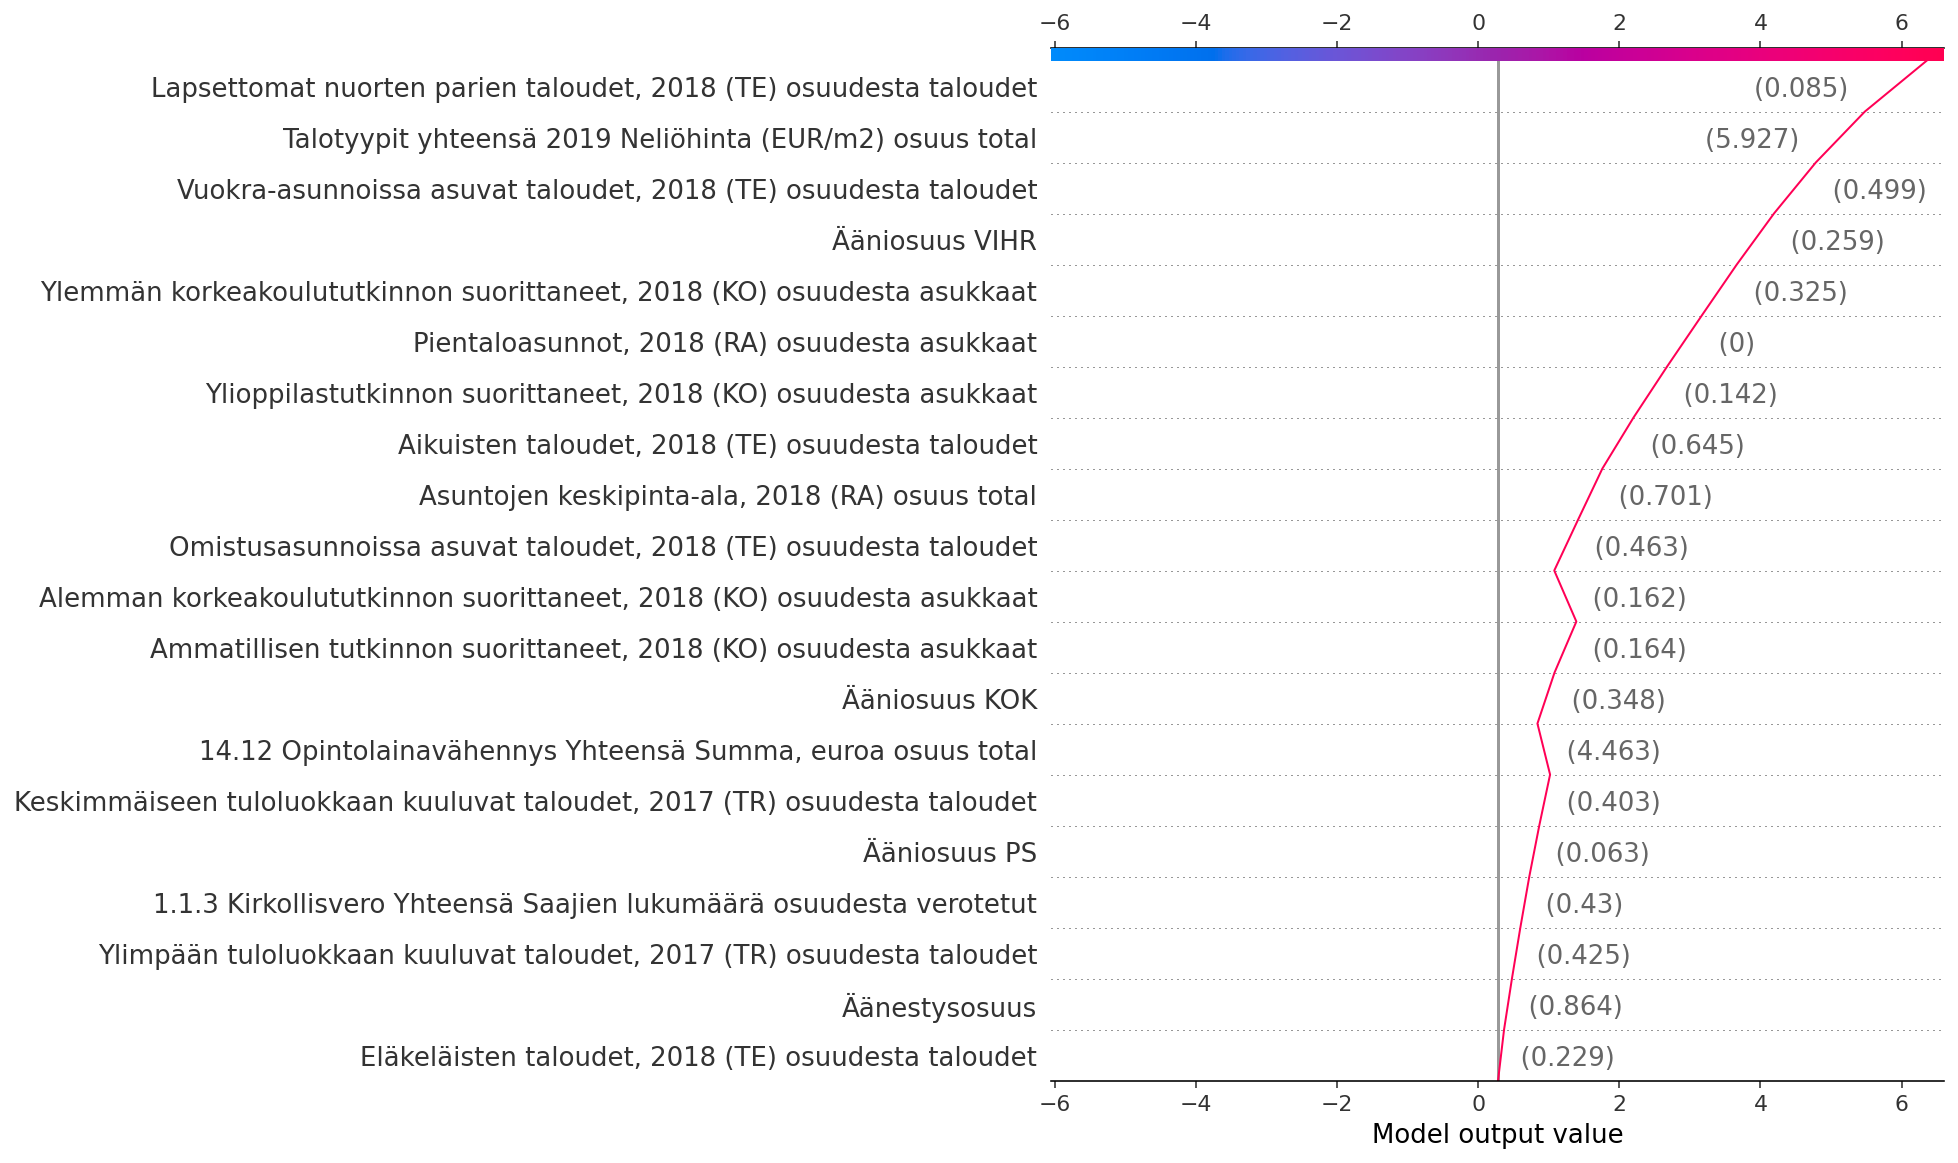

In [151]:
pnro = '02610'
id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
cluster = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[cluster], shap_values[cluster][idx], X)


In [149]:
data[data[id_col]==pnro][col_list]

14.12 Opintolainavähennys Yhteensä Summa, euroa osuus total  \
158                                                       1.2676   

     Vuokra-asunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
158                                                         0.637676   

     Lapsettomat nuorten parien taloudet, 2018 (TE) osuudesta taloudet  \
158                                                            0.07993   

     Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
158                                                        0.089088   

     Ylemmän korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
158                                                                 0.159964   

     Ääniosuus VIHR  Asuntojen keskipinta-ala, 2018 (RA) osuus total  \
158        0.200497                                         0.732526   

     Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
158                                                                 0.115951   

     Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
158                                                  3.119614   

     Pientaloasunnot, 2018 (RA) osuudesta asukkaat  ...  \
158                                       0.130824  ...   

     Omistusasunnoissa asuvat taloudet, 2018 (TE) osuudesta taloudet  \
158                                                         0.346831   

     Nuorten yksinasuvien taloudet, 2018 (TE) osuudesta taloudet  \
158                                                     0.146479   

     Postinumeroalueen pinta-ala osuus area_code  \
158                                     0.000309   

     Keskimmäiseen tuloluokkaan kuuluvat taloudet, 2017 (TR) osuudesta taloudet  \
158                                                                    0.474648   

     Ääniosuus KOK  Kesämökit yhteensä, 2018 (RA) osuudesta asukkaat  \
158       0.268434                                          0.000152   

     P Koulutus, 2017 (TP) osuudesta asukkaat  Ääniosuus PS  \
158                                  0.029747      0.130489   

     J Informaatio ja viestintä, 2017 (TP) osuudesta asukkaat  \
158                                                  0.014266   

     Eläkeläisten taloudet, 2018 (TE) osuudesta taloudet  
158                                             0.122183  

[1 rows x 23 columns]

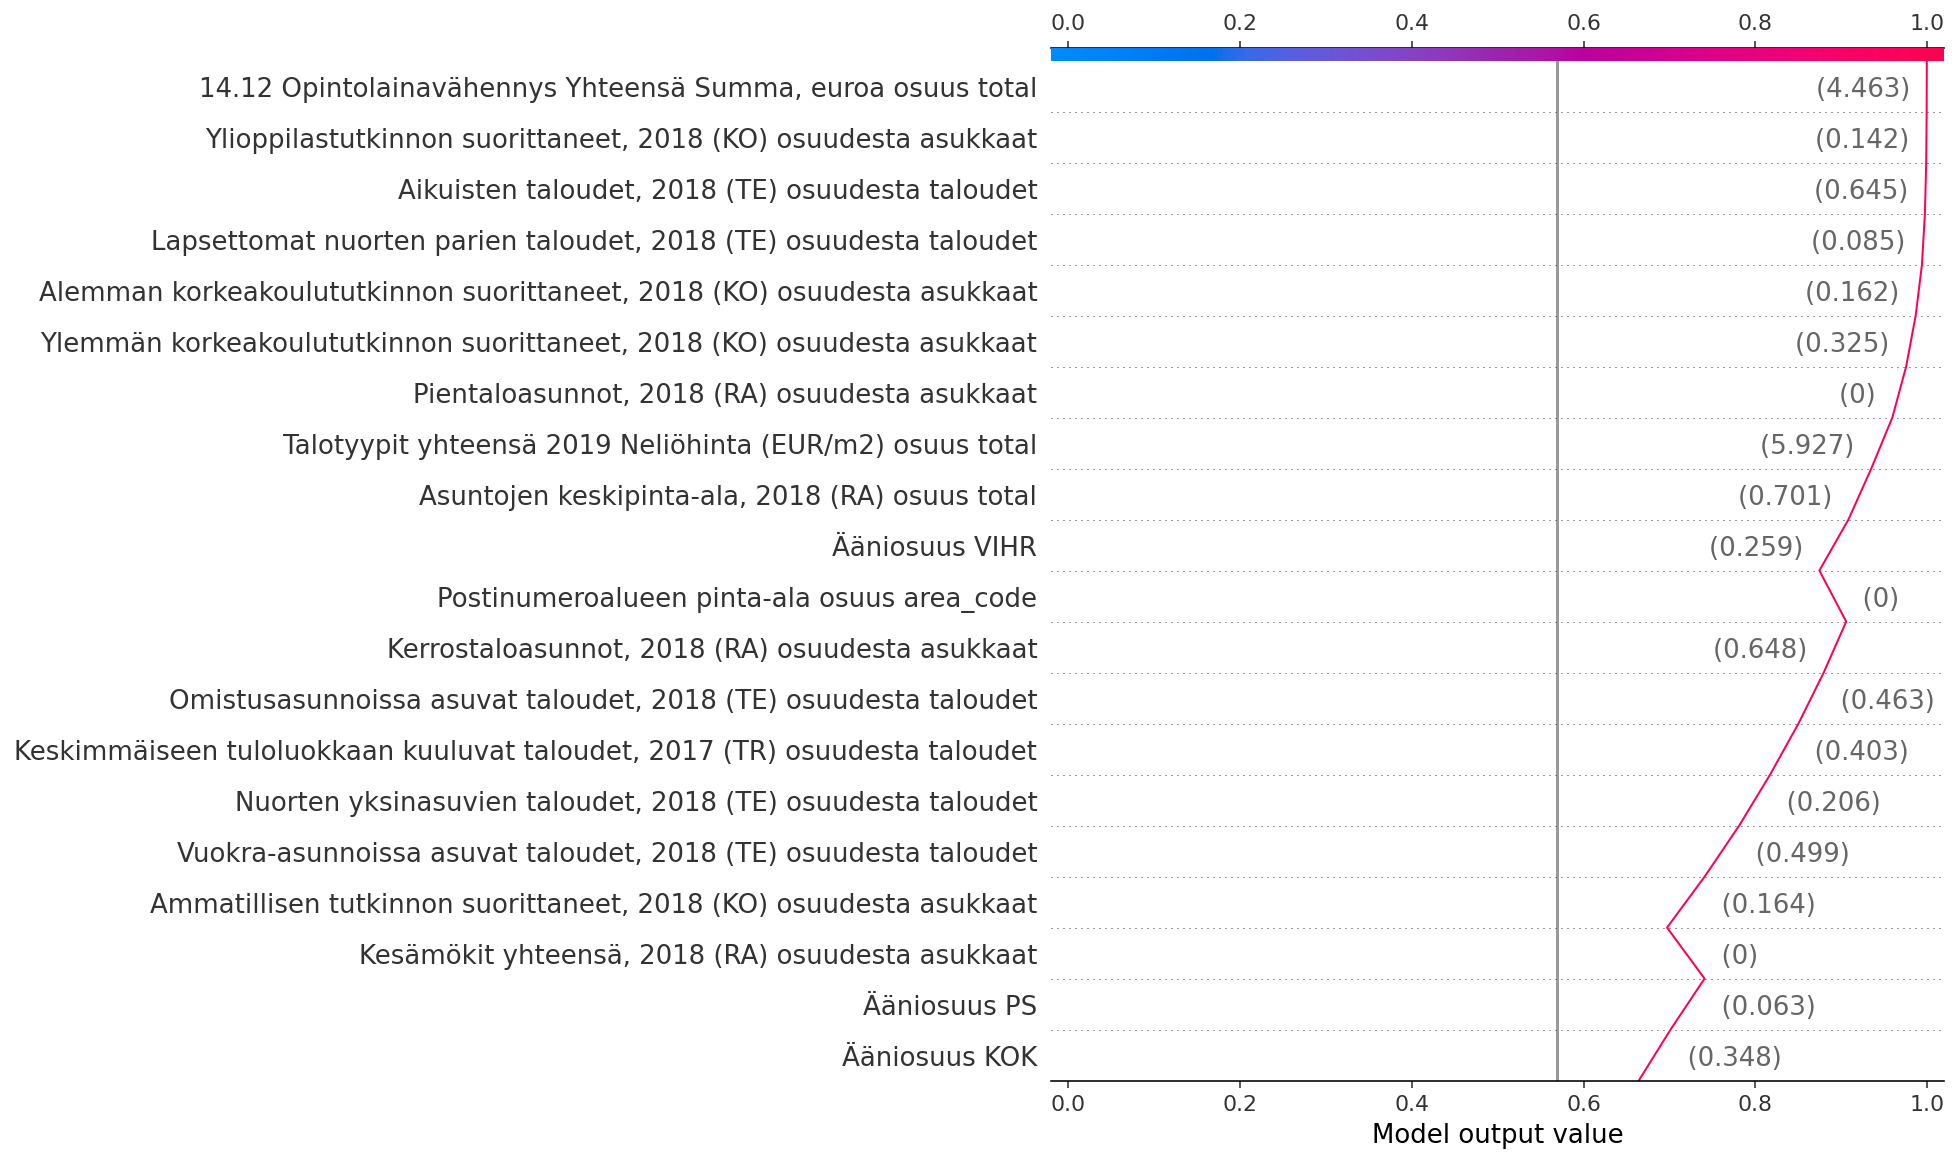

In [128]:

id_col = 'Postinumero'
target='cluster'
idx = data[data[id_col]==pnro].index.item()
cluster = data[data[id_col]==pnro][target].item()

shap.decision_plot(shap_expected_value[cluster], shap_values[cluster][idx], X, link='logit',)


In [126]:
new = ['Postinumero','muncipality_name','Asukkaat yhteensä, 2018 (HE)', target]
show_df, col_list = print_examples(data, X, new, target, 2, shap_values, col_num=23, n=6)
show_df

invalid value encountered in true_divide
invalid value encountered in true_divide


Postinumero muncipality_name  Asukkaat yhteensä, 2018 (HE)  cluster  \
2312       80130          Joensuu                        2380.0        2   
990        33250          Tampere                        2316.0        2   
26         00390         Helsinki                        6510.0        2   
18         00310         Helsinki                         913.0        2   
36         00540         Helsinki                        2910.0        2   
20         00330         Helsinki                        8818.0        2   

      Asuntojen keskipinta-ala, 2018 (RA) osuus total  \
2312                                             0.92   
990                                              0.71   
26                                               0.67   
18                                               0.54   
36                                               0.67   
20                                               0.75   

      Talotyypit yhteensä 2019 Neliöhinta (EUR/m2) osuus total  \
2312                                                      1.34   
990                                                       2.63   
26                                                        2.65   
18                                                        3.54   
36                                                        5.59   
20                                                        4.71   

      Postinumeroalueen pinta-ala osuus area_code  \
2312                                          0.0   
990                                           0.0   
26                                            0.0   
18                                            0.0   
36                                            0.0   
20                                            0.0   

      Ammatillisen tutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
2312                                                               0.27   
990                                                                0.29   
26                                                                 0.30   
18                                                                 0.25   
36                                                                 0.20   
20                                                                 0.19   

      Ylioppilastutkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
2312                                                            0.10   
990                                                             0.08   
26                                                              0.08   
18                                                              0.11   
36                                                              0.12   
20                                                              0.11   

      Alemman korkeakoulututkinnon suorittaneet, 2018 (KO) osuudesta asukkaat  \
2312                                                                     0.14   
990                                                                      0.14   
26                                                                       0.12   
18                                                                       0.20   
36                                                                       0.17   
20                                                                       0.14   

      ...  Lapsettomat nuorten parien taloudet, 2018 (TE) osuudesta taloudet  \
2312  ...                                                               0.09   
990   ...                                                               0.05   
26    ...                                                               0.05   
18    ...                                                               0.08   
36    ...                                                               0.13   
20    ...                                                               0.05   

      Aikuisten taloudet, 2018 (TE) osuudesta taloudet  \
2312               

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


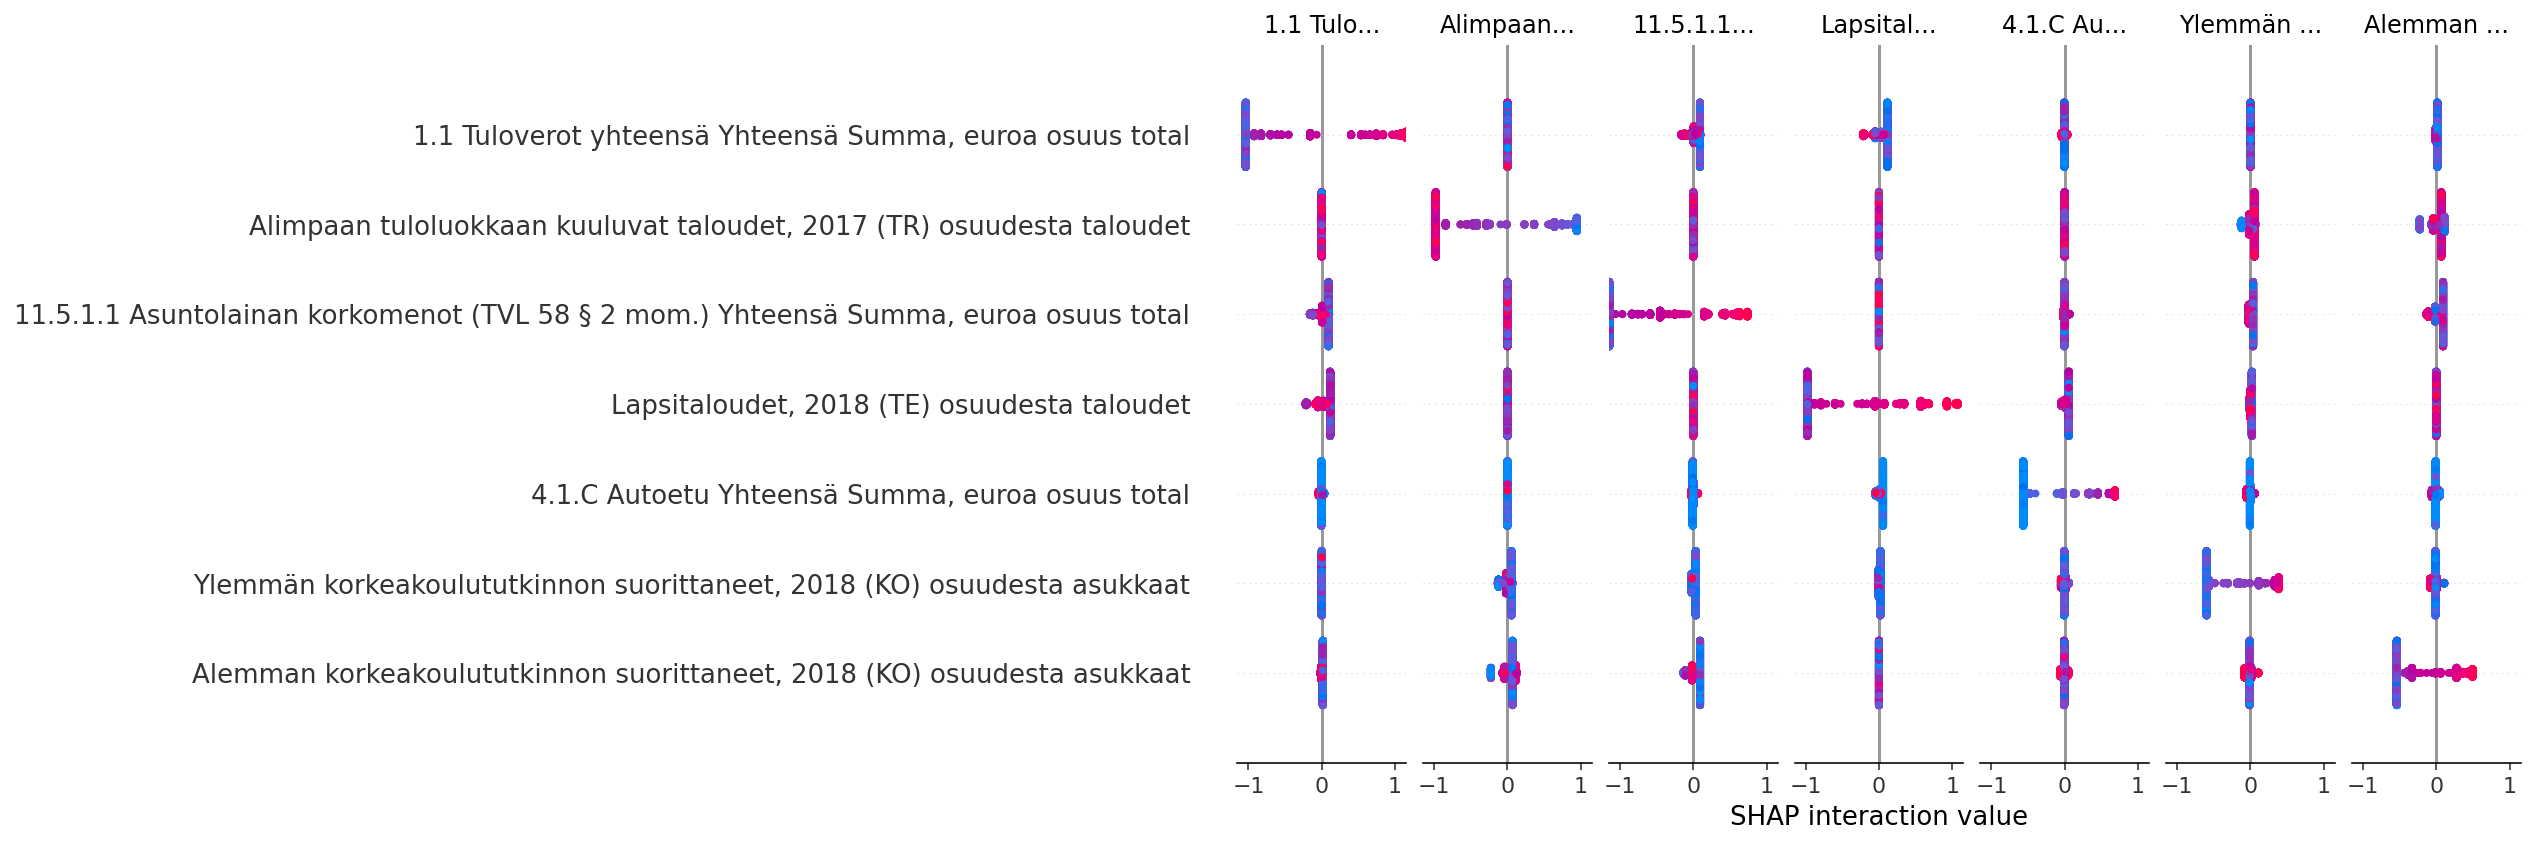

In [21]:
shap.summary_plot(shap_interaction_values[cluster], X)

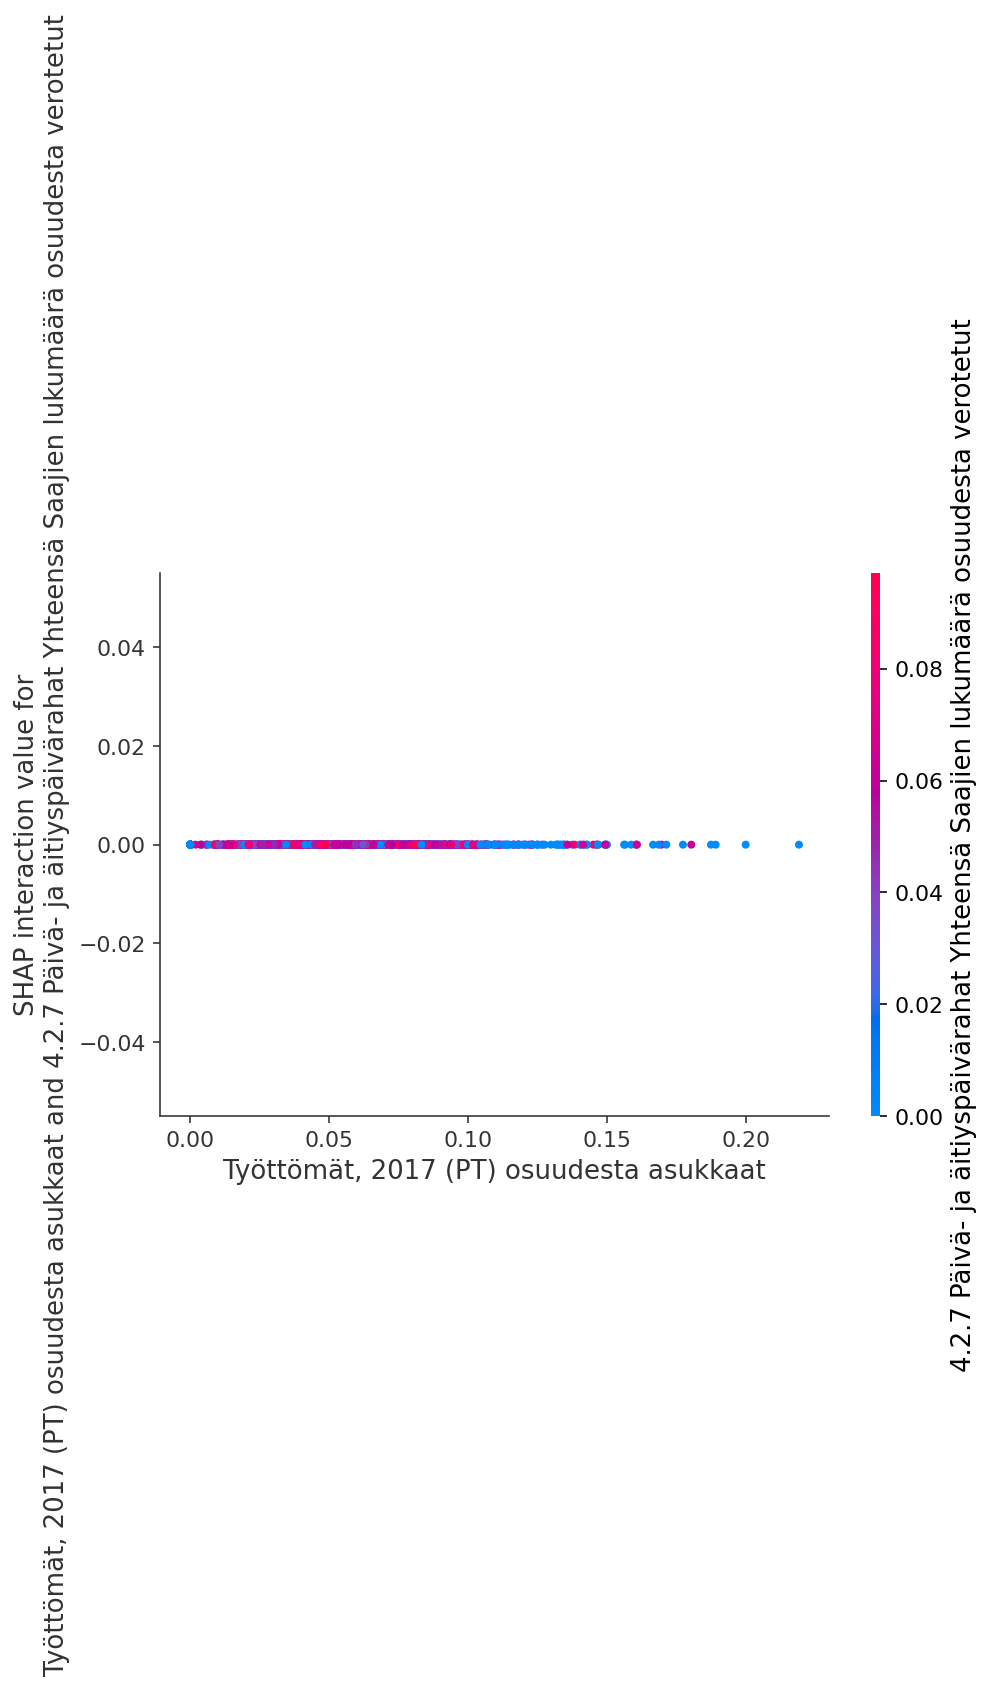

In [22]:
shap.dependence_plot(
    (col_list[0], col_list[1]),
    shap_interaction_values[cluster], X,
    display_features=X
)

In [23]:
data

Postinumero  0-2-vuotiaat, 2018 (HE)  13-15-vuotiaat, 2018 (HE)  \
0          00100                    394.0                      311.0   
1          00120                    155.0                      162.0   
2          00130                     41.0                       29.0   
3          00140                    216.0                      170.0   
4          00150                    238.0                      117.0   
...          ...                      ...                        ...   
2965       99930                      1.0                        4.0   
2966       99940                      0.0                        0.0   
2967       99950                     10.0                       14.0   
2968       99980                     11.0                       20.0   
2969       99990                      7.0                        9.0   

      16-17-vuotiaat, 2018 (HE)  18 vuotta täyttäneet yhteensä, 2017 (HR)  \
0                         199.0                                   16159.0   
1                          79.0                                    6170.0   
2                          24.0                                    1307.0   
3                          93.0                                    6767.0   
4                          80.0                                    8408.0   
...                         ...                                       ...   
2965                        2.0                                     211.0   
2966                        0.0                                      14.0   
2967                        3.0                                     240.0   
2968                       14.0                                     577.0   
2969                        3.0                                     178.0   

      18 vuotta täyttäneet yhteensä, 2018 (KO)  18-19-vuotiaat, 2018 (HE)  \
0                                      16273.0                      262.0   
1                                       6202.0                      106.0   
2                                       1319.0                       26.0   
3                                       6800.0                      121.0   
4                                       8304.0                      129.0   
...                                        ...                        ...   
2965                                     204.0                        2.0   
2966                                      16.0                        0.0   
2967                                     240.0                        5.0   
2968                                     580.0                       15.0   
2969                                     172.0                        3.0   

      20-24-vuotiaat, 2018 (HE)  25-29-vuotiaat, 2018 (HE)  \
0                        1531.0                     2515.0   
1                         511.0                      870.0   
2                          98.0                      160.0   
3                         539.0                      838.0   
4                         731.0                     1271.0   
...                         ...                        ...   
2965                        6.0                        6.0   
2966                        0.0                        0.0   
2967                        7.0                        9.0   
2968                       11.0                       20.0   
2969                        4.0                        9.0   

      3-6-vuotiaat, 2018 (HE)  ...  Pääomatulojen osuus  \
0                       514.0  ...             0.255523   
1                       227.0  ...             0.231248   
2                        47.0  ...             0.365380   
3                       254.0  ...             0.370543   
4                       281.0  ...             0.310732   
...                       ...  ...                  ...   
2965                      3.0  ...             0.054166   
2966                      0.0  ...             0.000000   
2967          

In [24]:
shap.waterfall_plot(shap_expected_value[0], shap_values[0[idx], X.iloc[idx,:], link='logit')


SyntaxError: invalid syntax (<ipython-input-24-cc7b8fecf954>, line 1)